# NLP Project

## Business Understanding

- This analysis uses tweets gathered from SXSW 2013 and attempts to predict customer sentiment toward Apple and Google products.
- Consumer sentiment toward brands can provide insight into the motivations behind their purchasing behaviors.

In [114]:
# imports

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from imblearn.over_sampling import RandomOverSampler


## Data Understanding

### Overview
- Source: https://data.world/crowdflower/brands-and-product-emotions
- Human raters evaluated 9K tweets and rated the sentiment as positive, negative, or no emotion.
- The tweets were gathered from the 2013 South by Southwest Festival, a festival centered around art, music, and new technology.
- Target: positive/negative sentiment

### Data Cleaning

In [82]:
# import data
df = pd.read_csv("data/brands_and_product_tweets.csv")

# rename columns for readability
df = df.rename(columns = {'tweet_text': 'tweet',
                          'emotion_in_tweet_is_directed_at': 'product',
                          'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})

df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [83]:
# rename sentiment labels
df['sentiment'] = df['sentiment'].replace({"No emotion toward brand or product": "neutral",
                                           "Positive emotion": "positive",
                                           "Negative emotion": "negative",
                                           "I can't tell": "unclear"})
df['sentiment'].value_counts()

neutral     5156
positive    2869
negative     545
unclear      151
Name: sentiment, dtype: int64

In [84]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

In [85]:
# explore null values
df.isna().sum()

tweet           1
product      5539
sentiment       0
dtype: int64

In [86]:
# drop rows with null 'tweet'
df.dropna(subset=['tweet'], inplace=True)

In [87]:
# fill null 'product' with 'unassigned'
df['product'].fillna('unassigned', inplace = True)

# view distribution of product labels
df['product'].value_counts()

unassigned                         5538
iPad                                909
Apple                               638
iPad or iPhone App                  450
Google                              410
iPhone                              287
Other Google product or service     282
Android App                          77
Android                              73
Other Apple product or service       34
Name: product, dtype: int64

In [88]:
# categorize products by brand

# create column 'brand' with default value 'NA'
df['brand'] = 'NA'

# define conditions using 'product' name
product_apple = df['product'].str.contains('apple|ip', case=False)
product_google = df['product'].str.contains('google|android', case=False)

# fill in 'brand' using defined conditions
df.loc[product_apple, 'brand'] = 'apple'
df.loc[product_google, 'brand'] = 'google'

# view distribution of of brand labels
df.groupby(['brand', 'product']).size()

brand   product                        
NA      unassigned                         5538
apple   Apple                               638
        Other Apple product or service       34
        iPad                                909
        iPad or iPhone App                  450
        iPhone                              287
google  Android                              73
        Android App                          77
        Google                              410
        Other Google product or service     282
dtype: int64

In [90]:
### WIP ###

# define function to identify brand mentioned in tweet text

def tweet_brand(row):
    tweet_apple = row['tweet'].str.contains('apple|iphone|ipad', case=False)
    tweet_google = row['tweet'].str.contains('google|android', case=False)

    if row['brand'] == 'NA':    
        if tweet_apple and tweet_google:
            return 'both'
        elif tweet_apple:
            return 'apple'
        elif tweet_google:
            return 'google'
    return row['brand']

# apply the function to each row and return results to 'brand'
df['brand'] = df.apply(tweet_brand, axis=1)


#df['brand'].value_counts()
#df.groupby(['brand', 'product']).size()

AttributeError: 'str' object has no attribute 'str'

In [91]:
# reset index after dropping rows
df.reset_index(drop=True, inplace=True)
df

,tweet,product,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google
...,...,...,...,...
8693,Ipad everywhere. #SXSW {link},iPad,positive,apple
8694,"Wave, buzz... RT @mention We interrupt your re...",unassigned,neutral,NA
8695,"Google's Zeiger, a physician never reported po...",unassigned,neutral,NA
8696,Some Verizon iPhone customers complained their...,unassigned,neutral,NA


### Data Visualization

In [92]:
# function to build countplot for specified columns

def tweet_countplot(df, col, hue=None):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(data=df, x=col, hue=hue, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'distribution of tweets by {col}')
    plt.show()


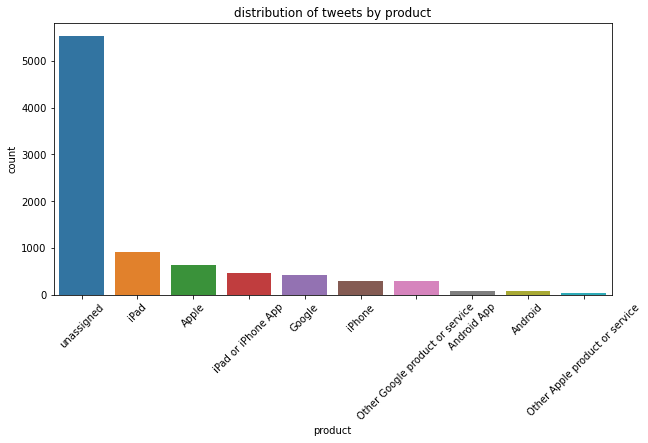

In [ ]:
tweet_countplot(df, 'product')

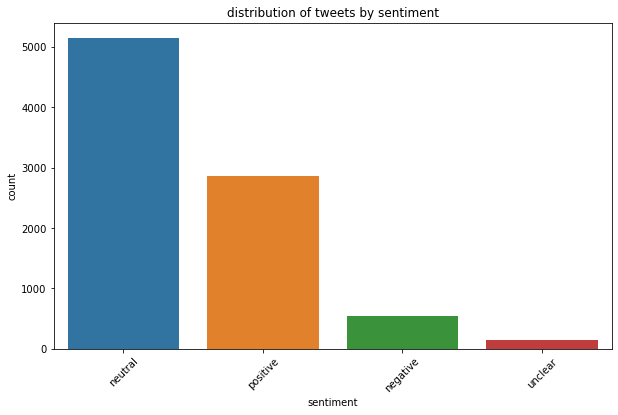

In [ ]:
tweet_countplot(df, 'sentiment')

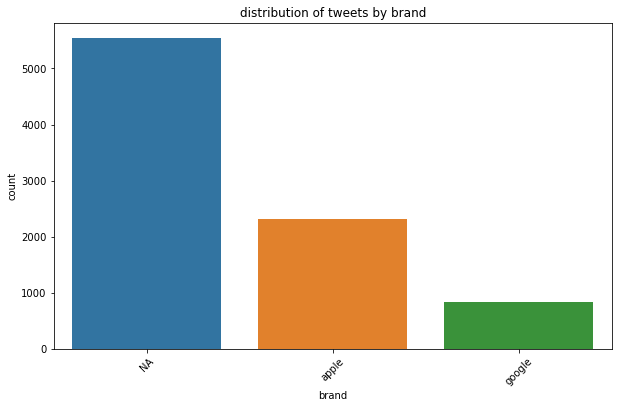

In [ ]:
tweet_countplot(df, 'brand')

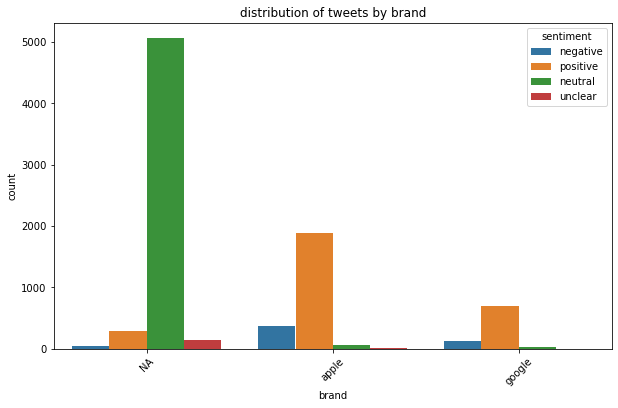

In [ ]:
tweet_countplot(df, 'brand', hue='sentiment')

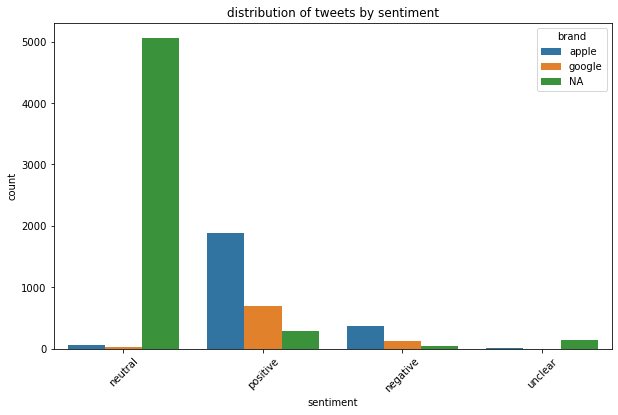

In [ ]:
tweet_countplot(df, 'sentiment', hue='brand')

## Modeling & Evaluation

### Preprocessing

In [93]:
sw = stopwords.words('english')
new_sw = ['sxsw','link', 'rt']
sw.extend(new_sw)

tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
# pattern to grab words with 3 characters or more

lemmer = WordNetLemmatizer()
#p_stemmer = PorterStemmer()
#s_stemmer = SnowballStemmer()

In [94]:
def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ''  # Return empty string if text is not a string
    # Remove URLs items
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    #stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in sw])
    
    return text

# Clean the tweet_text column
#df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_text)

In [95]:
# Function to lemmatize text
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each word
    lemmatized_tokens = [lemmer.lemmatize(token) for token in tokens]
    # Rejoin lemmatized tokens into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Example text
example_text = "Fall Out Boy Rules."

# Lemmatize the example text
lemmatized_text = lemmatize_text(example_text)
print(lemmatized_text)

Fall Out Boy Rules .


In [96]:
df['sentiment'].value_counts()

neutral     5142
positive    2861
negative     544
unclear      151
Name: sentiment, dtype: int64

In [97]:
# Map textual sentiment labels to numerical values
sentiment_mapping = {
    "neutral": 0,
    "positive": 1,
    "negative": -1,
    "unclear": None  # You might choose to exclude these or handle them differently
}

# Apply the mapping to your sentiment label column
df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)

# Drop rows where 'sentiment_label' is NaN
# df = df.dropna(subset=['sentiment_label'])

# Check the first few rows to ensure the mapping is applied correctly
df['sentiment_label'].value_counts()

 0.0    5142
 1.0    2861
-1.0     544
Name: sentiment_label, dtype: int64

In [98]:
df['cleaned_text'] = df['tweet'].apply(clean_text)
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

df.head()

,tweet,product,sentiment,brand,sentiment_label,cleaned_text,lemmatized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple,-1.0,g iphone hrs tweeting rise austin dead need up...,g iphone hr tweeting rise austin dead need upg...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple,1.0,know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple,1.0,wait ipad also sale,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple,-1.0,hope year's festival crashy year's iphone app,hope year 's festival crashy year 's iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google,1.0,great stuff fri marissa mayer google tim o'rei...,great stuff fri marissa mayer google tim o'rei...


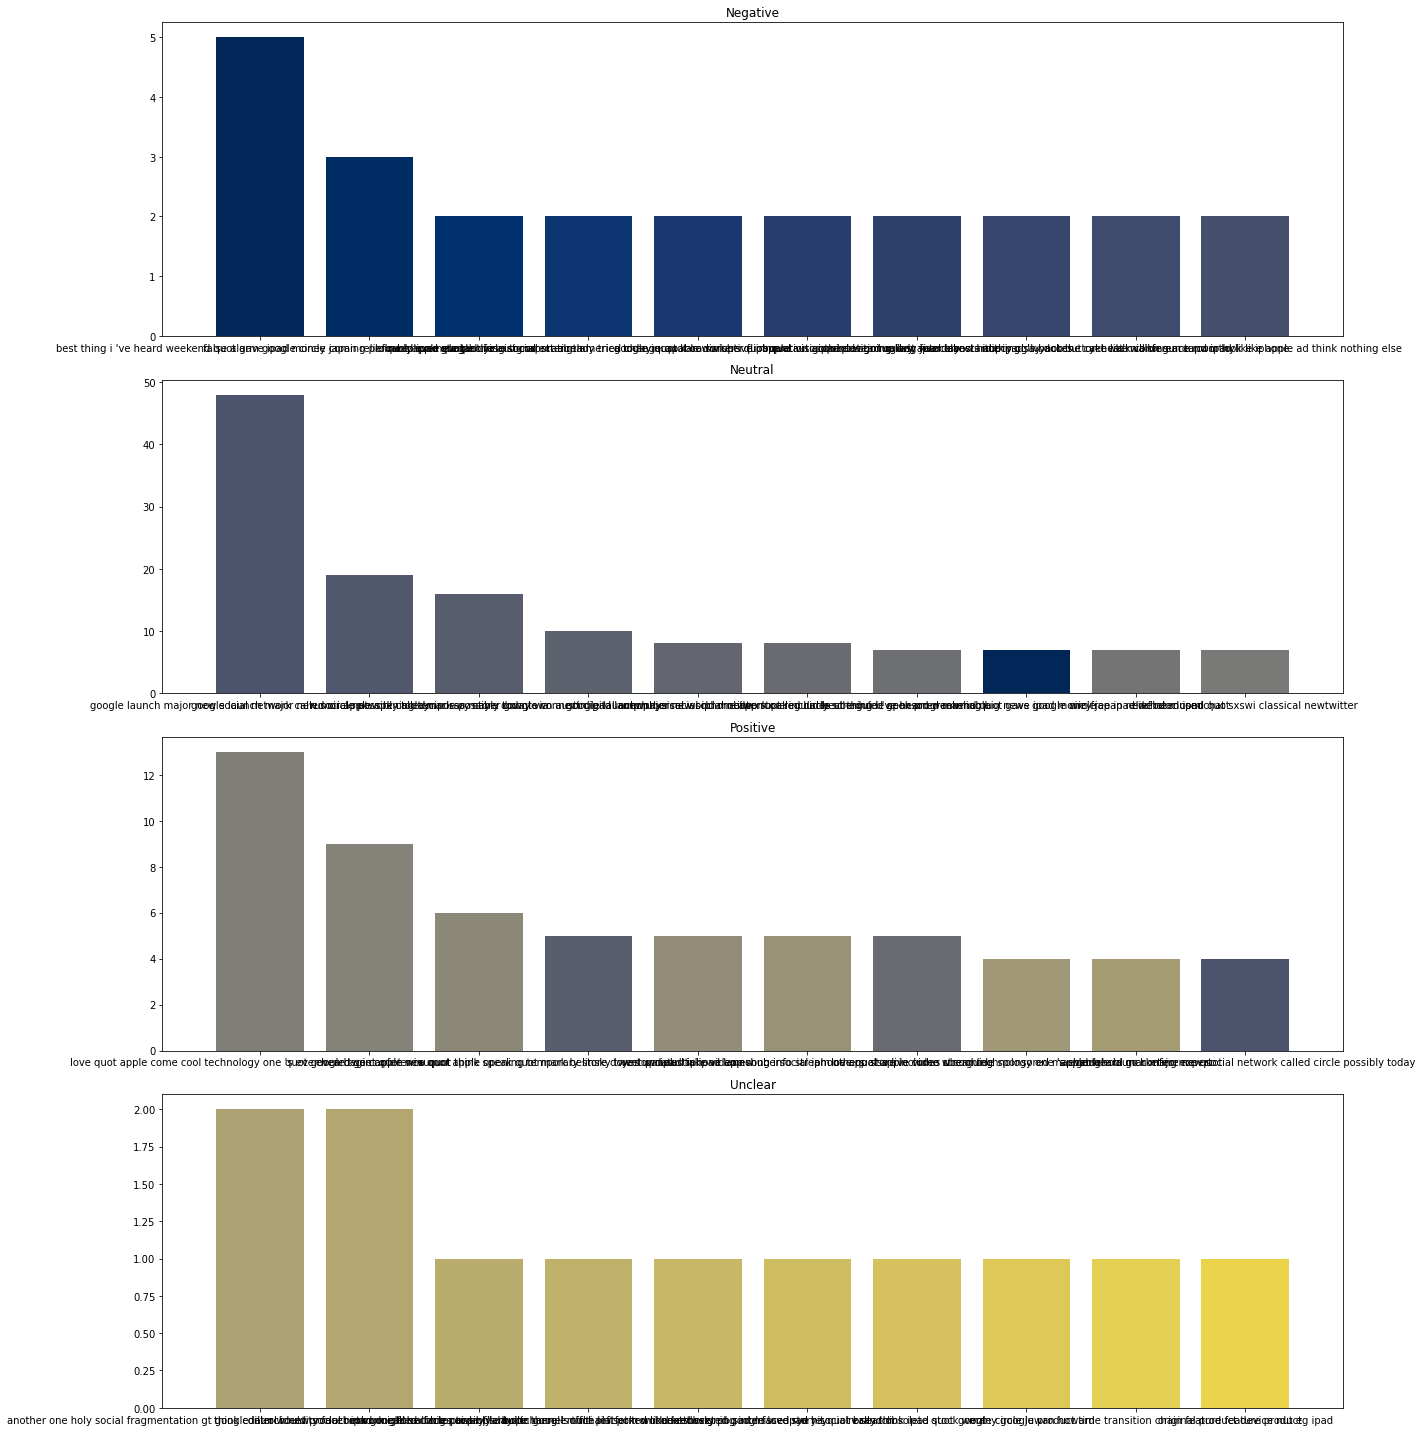

In [100]:
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))

# Empty dictionary to hold words that have been plotted and their colors
plotted_words_and_colors = {}
# Choose a color palette
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique genre
data_by_sentiment = [y for _, y in df.groupby('sentiment', as_index=False)]
for idx, sentiment_df in enumerate(data_by_sentiment):
    # Find top 10 words in this genre
    all_words_in_sentiment = sentiment_df.lemmatized_text.explode()
    top_10 = all_words_in_sentiment.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
#    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(sentiment_df.iloc[0].sentiment.title())
      
fig.tight_layout();

In [107]:
# instantiate CountVectorizer
count_vect = CountVectorizer()

# fit and transform lemmatized text
count_matrix = count_vect.fit_transform(df['lemmatized_text'])

# convert count matrix to a DataFrame
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vect.get_feature_names())

count_df.head()

,aapl,aaron,ab,abacus,abandoned,abba,abc,aber,ability,able,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
# Display the frequency table
freq_table = count_df.sum(axis=0).sort_values(ascending=False).reset_index()
freq_table.columns = ['Term', 'Frequency']
freq_table.head(20)

,Term,Frequency
0,ipad,2891
1,google,2539
2,apple,2218
3,quot,1621
4,iphone,1529
5,store,1458
6,new,1059
7,austin,936
8,amp,798
9,app,796


In [115]:
#instantiate TF-IDF vectorizer
tf_vect = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
tf = tf_vect.fit_transform(df.lemmatized_text)

tf_vect_df = pd.DataFrame(tf.toarray(), columns=tf_vect.get_feature_names())
tf_vect_df.head()

,aapl,aaron,ab,abacus,abandoned,abba,abc,aber,ability,able,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modeling
- Logistic Regression (with PCA?)
- Multinomial Naïve Bayes
- Random Forest 


In [120]:
# train test split
X = count_df
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [118]:
# logistic regression

logreg_model = LogisticRegression(max_iter=100)
logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [119]:
# multinomal naive bayes
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# decision tree

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

In [ ]:
# random forest

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

### Evaluation Metrics
- false positives - classify as customer likes the product when they do not 
- false negatives - classify as customer does not like product when they do

## Conclusion